In [ ]:
##########

In [ ]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install datasets transformers
import pandas as pd
import transformers
print(transformers.__version__)

4.16.1


In [5]:
## Reading Dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Files/training_set_rel3(12k).tsv', sep='\t', encoding='ISO-8859-1')
df = df.drop(columns=['rater3_domain1', 'rater1_domain2', 'rater2_domain2',
                       'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3',
                        'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1',
                       'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5',
                       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
                        'rater3_trait4', 'rater3_trait5', 'rater3_trait6', 'rater1_domain1', 'rater2_domain1'])

## Spliting up in its 8 prompts
df_1 = df[0:1783]
df_2 = df[1784:3583]
df_3 = df[3584:5309]
df_4 = df[5309:7079]
df_5 = df[7080:8884]
df_6 = df[8885:10684]
df_7 = df[10685:12253]
df_8 = df[12253:12977]

In [ ]:
# Testing: Normalize and combine 3 columns in one
column = 'domain1_score'

df_1['final_score'] = ((df_1[column] - df_1[column].min()) / (df_1[column].max() - df_1[column].min()))*10
df_2['final_score'] = ((df_2[column] - df_2[column].min()) / (df_2[column].max() - df_2[column].min()))*10
df_3['final_score'] = ((df_3[column] - df_3[column].min()) / (df_3[column].max() - df_3[column].min()))*10
df_4['final_score'] = ((df_4[column] - df_4[column].min()) / (df_4[column].max() - df_4[column].min()))*10
df_5['final_score'] = ((df_5[column] - df_5[column].min()) / (df_5[column].max() - df_5[column].min()))*10
df_6['final_score'] = ((df_6[column] - df_6[column].min()) / (df_6[column].max() - df_6[column].min()))*10
df_7['final_score'] = ((df_7[column] - df_7[column].min()) / (df_7[column].max() - df_7[column].min()))*10
df_8['final_score'] = ((df_8[column] - df_8[column].min()) / (df_8[column].max() - df_8[column].min()))*10

df_1['final_score'] = df_1['final_score'].round(1).astype('int')
df_2['final_score'] = df_2['final_score'].round(1).astype('int')
df_3['final_score'] = df_3['final_score'].round(1).astype('int')
df_4['final_score'] = df_4['final_score'].round(1).astype('int')
df_5['final_score'] = df_5['final_score'].round(1).astype('int')
df_6['final_score'] = df_6['final_score'].round(1).astype('int')
df_7['final_score'] = df_7['final_score'].round(1).astype('int')
df_8['final_score'] = df_8['final_score'].round(1).astype('int')

In [7]:
result = df_1.append([df_2, df_3, df_4, df_5, df_6, df_7, df_8], ignore_index=True)
#result = df_1.append([df_7, df_8], ignore_index=True)
df = result

In [8]:
print(df[df['domain1_score'].isnull()])
print(df[df['essay'].isnull()])

Empty DataFrame
Columns: [essay_id, essay_set, essay, domain1_score, final_score]
Index: []
Empty DataFrame
Columns: [essay_id, essay_set, essay, domain1_score, final_score]
Index: []


In [9]:
df = df.dropna()
df['essay'].dropna(inplace=True)
#df['domain1_score'].dropna(inplace=True)
#df.head()

In [10]:
X = df.drop('domain1_score', axis = 1)
print(len(X['essay'][0]))
max_len = X['essay'].apply(lambda x: len(x)).max()
print(max_len)

1875
6098


In [11]:
y = df['domain1_score'].astype(int) 
#y = df['domain1_score']
#pd.to_numeric(y, downcast="integer")
print(df[df['domain1_score'].isnull()])

Empty DataFrame
Columns: [essay_id, essay_set, essay, domain1_score, final_score]
Index: []


In [12]:
## df[df['essay_set']==1]['domain1_score']

In [16]:
#min_range = [2,1,0,0,0,0,0,0]
#max_range = [12,6,3,3,4,4,30,60]

#def normalize(x,mi,ma):
    #print("Before Normalization: "+str(x))
#    x = (x-mi)/(ma-mi)
    #print("After Normalization : "+str(x))
#    return round(x*10)

#df['final_score']=df.apply(lambda x:normalize(x['domain1_score'],min_range[x['essay_set']-1],max_range[x['essay_set']-1]),axis=1)

In [17]:
## df['final_score'].value_counts()

In [13]:
df.head()

,essay_id,essay_set,essay,domain1_score,final_score
0,1,1,"Dear local newspaper, I think effects computer...",8,6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,8
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,6


In [14]:
df.drop('domain1_score',axis=1,inplace=True)

In [15]:
y = df['final_score']

In [16]:
X.shape

(12971, 4)

In [17]:
y.shape

(12971,)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense

In [19]:
## voc_size = 10000

In [20]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
cap = ['@CAPS'+str(i) for i in range(100)]
loc = ['@LOCATION'+str(i) for i in range(100)]
org =['@ORGANIZATION'+str(i) for i in range(100)]
per = ['@PERSON'+str(i) for i in range(100)]
date = ['@DATE'+str(i) for i in range(100)]
time = ['@TIME'+str(i) for i in range(100)]
money = ['@MONEY'+str(i) for i in range(100)]
ner =  cap + loc + org + per + date + time + money

In [22]:
#from nltk.stem.porter import PorterStemmer
#ps = PorterStemmer()
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn

word_Lemmatized = WordNetLemmatizer()
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

essays = X.copy()
corpus = []
for i in range (0, len(essays)):
    #print(i)
    review = re.sub('[^a-zA-Z]', ' ', essays['essay'][i])
    review = review.lower()
    review = review.split()
    #review = stopwords.words('english')
    #review = review.extend(ner)

    review = [word_Lemmatized.lemmatize(word, tag_map[0]) for word in review if not word in stopwords.words('english')]
    #review.extend(ner)
    review = ' '.join(review)
    corpus.append(review)

In [23]:
corpus[5]

'dear location think computer negative affect u many people ace camputer daily america num many people go least hour num mean num people cant exercise wasting many posibility physical cap sound good think everything done write letter got got material sit back done writing put material away put letter mailbox walk way back well think write email sitdown move finger see difference cap instead getting good walk friend house talk er know literally computer instead around add anything computer give away information information lead everthing wouldbe gone go online believe phisically get hurt computer long num thing computer cap happened grandpa wood chair day get ardthritis muscle cap thing th'

In [ ]:
#onehot_rep = [one_hot(words, voc_size) for words in corpus]
#onehot_rep [0:2]

In [27]:
hparams = {
    "batch_size": 128,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 6e-5,
    "max_num_words": 10000,
    "max_sequence_length": 256
} 

In [28]:
import numpy as np
text = df['essay'].tolist()
#text_final = df['text_final'].tolist()
#text do_lower_case=True
#text = X['essay'].to_numpy()
#text

In [92]:
from tensorflow.keras.layers import GRU, Dropout, Conv1D, MaxPooling1D, concatenate, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model

## from transformers import BertTokenizer, TFBertModel
## from transformers import RobertaTokenizer, TFRobertaModel
## from transformers import ElectraTokenizer, TFElectraModel
## from transformers import OpenAIGPTTokenizer, TFOpenAIGPTModel
from transformers import GPT2Tokenizer, TFGPT2Model
## from transformers import AutoModel, AutoTokenizer 
import tensorflow as tf

In [119]:
with strategy.scope():
  ## bert_tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')
  ## bert_model = TFBertModel.from_pretrained('distilbert-base-uncased')
  ## bert_model.trainable = False
  ## roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
  ## roberta_model = TFRobertaModel.from_pretrained('roberta-large')
  ## roberta_model.trainable = False 
  ## roberta_model.output_hidden_states = False
  ## roberta_tokenizer.output_hidden_states = False
  ## ELECTRA_tokenizer = ElectraTokenizer.from_pretrained('google/electra-large-discriminator')
  ## ELECTRA_model = TFElectraModel.from_pretrained('google/electra-large-discriminator')
  ## ELECTRA_model.trainable = False
  gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
  gpt_model = TFGPT2Model.from_pretrained("gpt2")
  gpt_model.trainable = False
  gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
  ## xlm-roberta_model = AutoModel.from_pretrained("xlm-roberta-base")
  ## xlm-roberta_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
  ## xlm-roberta_model.trainable = False

  tokenizer_in = gpt_tokenizer(text, padding=True, 
                                       truncation=True, 
                                       add_special_tokens=True,
                                       max_length=hparams["max_sequence_length"], 
                                       return_tensors="tf",
                                       verbose = True)
  input_ids = tokenizer_in.input_ids
  attention_masks = tokenizer_in.attention_mask 
  ## token_type_ids = tokenizer_in.token_type_ids

  ## embedding_layer = roberta_model(input_ids, attention_mask = attention_masks)
  ## sequence_output = embedding_layer.last_hidden_state

  ## embedding_layer = bert_model(input_ids, attention_mask = attention_masks, token_type_ids = token_type_ids)
  ## sequence_output = embedding_layer.last_hidden_state

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [28]:
## !pip  install sentence_transformers
## from sentence_transformers import SentenceTransformer
## model = SentenceTransformer('all-mpnet-base-v2')
## sentence_embeddings = model.encode(corpus)
## sentence_embeddings

In [120]:
from keras import regularizers
with strategy.scope():
  # define set of input 
  input_ids_in = Input(shape=hparams["max_sequence_length"], dtype=tf.int32, name='input_ids')
  input_masks_in = Input(shape=hparams["max_sequence_length"], dtype=tf.int32, name='attention_masks') 
  ## token_type_ids_in = Input(shape=hparams["max_sequence_length"], dtype=tf.int32, name='token_type_ids')


  embedding_layer = gpt_model(input_ids_in, attention_mask = input_masks_in)
  sequence_output = embedding_layer.last_hidden_state
  #pooled_output = embedding_layer.pooler_output
  #print('=======================')
  #print(sequence_output)
  #print('=======================')
  #print(pooled_output)
  ## token_type_ids = token_type_ids_in

  # the first branch operates on the first input
  x = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(sequence_output)
  x = GlobalAveragePooling1D()(x)

  xx = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(sequence_output)
  xx = GlobalAveragePooling1D()(xx)

  # the second branch opreates on the second input Bidirectional(
  yy = Bidirectional(LSTM(50, recurrent_dropout=0, return_sequences=False))(sequence_output)

  # combine the output of the two branches
  combined = concatenate([x,xx,yy])

  # apply a FC layer and then a regression prediction on the combined outputs
  out = Dense(64, input_dim=64, kernel_regularizer=regularizers.l2(0.01))(combined)
  out = Dense(64, activation="relu")(out)
  #out = tf.keras.layers.BatchNormalization()(out)
  #out = Dropout(0.1)(sentence_embeddings)

  out = Dense(32, activation="relu")(out)
  #out = tf.keras.layers.BatchNormalization()(out)
  #out = Dropout(0.1)(sentence_embeddings)

  out = Dense(16, activation="relu")(out)

  out = Dense(1, activation="linear")(out)

  # our model will accept the inputs of the two branches and then output a single value
  model = Model(inputs=[input_ids_in, input_masks_in], outputs=out)
  ## model = Model(inputs=[input_ids_in, input_masks_in, token_type_ids_in], outputs=out)

  ## Creating the model_3
  #def get_model():
  #embedding_vector_features=50
  #return model 
  #model = get_model()
  la_opt_adam = tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"], epsilon=1e-08)
  model.compile(loss='mean_squared_error',optimizer=la_opt_adam , metrics=['mean_squared_error'])
  print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 tfgpt2_model_1 (TFGPT2Model)   TFBaseModelOutputWi  124439808   ['input_ids[0][0]',              
                                thPastAndCrossAtten               'attention_masks[0][0]']        
                                tions(last_hidden_s                                               
                                tate=(None, 256, 76                                         

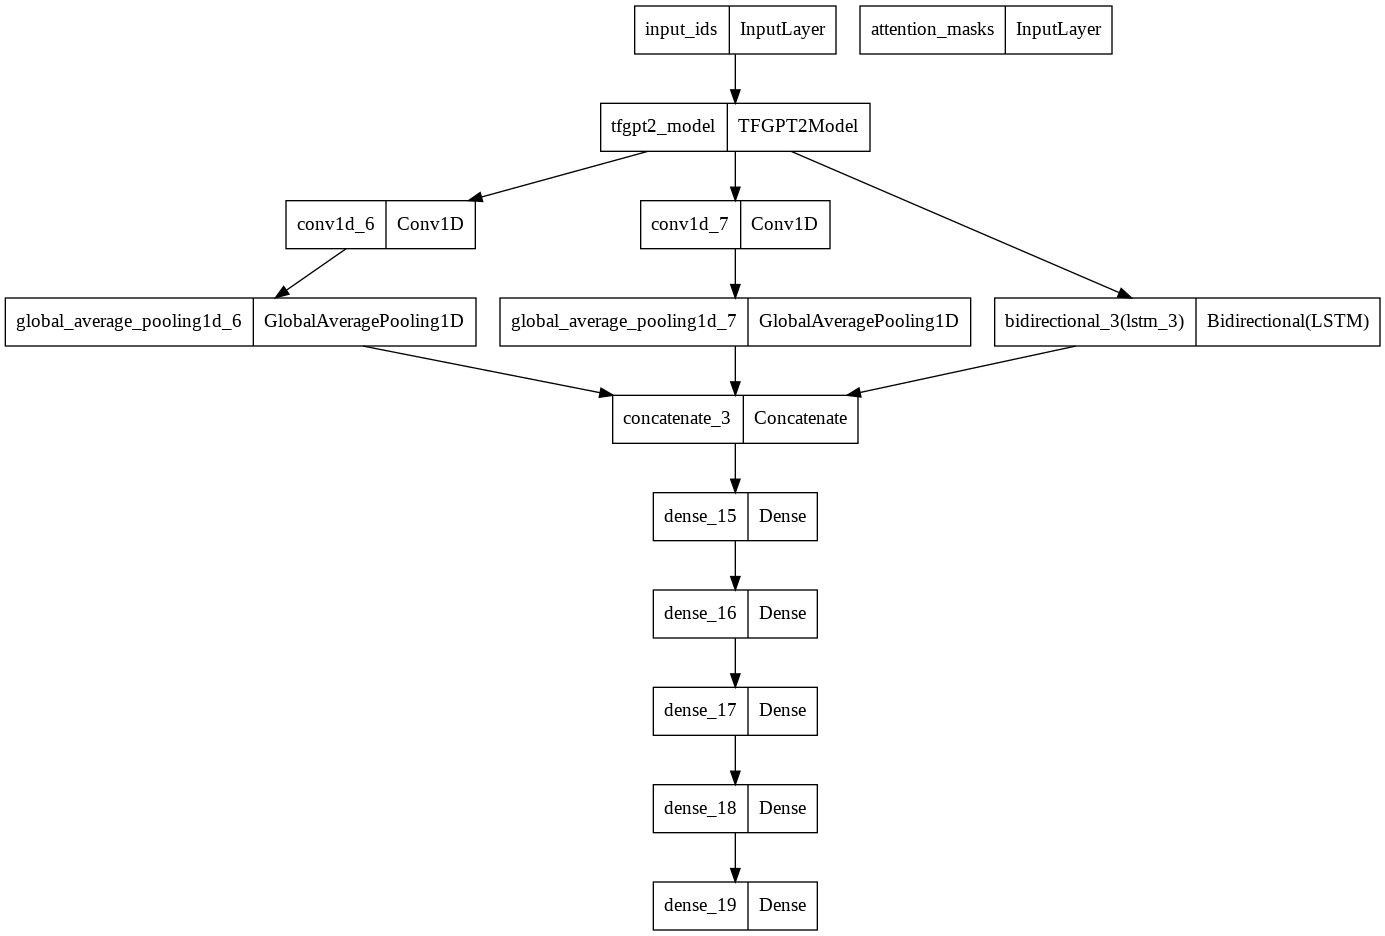

In [98]:
from tensorflow.keras.utils import plot_model, model_to_dot
plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/Transformers/OpenAI GPT2 Model_plot.png', show_shapes=False, 
                                                                                                show_layer_names=True,
                                                                                                expand_nested=False,
                                                                                                dpi = 96)

In [121]:
import numpy as np
X_final_1=np.array(input_ids)  
X_final_2=np.array(attention_masks)
## X_final_3=np.array(token_type_ids)

y_final=np.array(y)

In [122]:
X_final_1.shape

(12971, 256)

In [123]:
from sklearn.model_selection import train_test_split
## X_train_1, X_test_1, X_train_2, X_test_2, X_train_3, X_test_3, y_train, y_test = train_test_split(X_final_1, X_final_2, X_final_3, y_final, 
##                                                                                                 test_size=0.20, random_state=42)

X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(X_final_1, X_final_2, y_final, test_size=0.20, random_state=42)

In [124]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
class_weights = dict(enumerate(class_weights))

In [125]:
class_weights

{0: 2.5914085914085914,
 1: 42.87603305785124,
 2: 1.6548644338118021,
 3: 0.841456491768713,
 4: 0.9704451926674149,
 5: 0.7108309926697266,
 6: 0.3627972027972028,
 7: 0.5925079945180448,
 8: 2.0285434995112412,
 9: 5.044239183276616,
 10: 0.815979867882982}

In [126]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/checkpoint-OpenAI-GPT2-Model.h5', 
                             verbose = 1, save_best_only = True, save_weights_only = False)
earlyStop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'auto')

callbacksList = [checkpoint, earlyStop]
## Training  
history = model.fit([X_train_1, X_train_2], y_train, validation_data=([X_test_1, X_test_2], y_test),
                    epochs=50,batch_size=64, callbacks = callbacksList, class_weight=class_weights)

## history = model.fit([X_train_1, X_train_2, X_train_3], y_train, validation_data=([X_test_1, X_test_2, X_test_3], y_test),
##                     epochs=500,batch_size=64, callbacks = callbacksList, class_weight=class_weights)

model.load_weights("/content/drive/MyDrive/Colab Notebooks/checkpoint-OpenAI-GPT2-Model.h5")

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 6.8535 - mean_squared_error: 5.1900
Epoch 00001: val_loss improved from inf to 5.40687, saving model to /content/drive/MyDrive/Colab Notebooks/checkpoint-OpenAI-GPT2-Model.h5
163/163 [==============================] - 71s 245ms/step - loss: 6.8535 - mean_squared_error: 5.1900 - val_loss: 5.4069 - val_mean_squared_error: 4.4428
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 4.6477 - mean_squared_error: 3.5478
Epoch 00002: val_loss improved from 5.40687 to 4.56631, saving model to /content/drive/MyDrive/Colab Notebooks/checkpoint-OpenAI-GPT2-Model.h5
163/163 [==============================] - 18s 110ms/step - loss: 4.6477 - mean_squared_error: 3.5478 - val_loss: 4.5663 - val_mean_squared_error: 3.6387
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 4.0029 - mean_squared_error: 3.0595
Epoch 00003: val_loss improved from 4.56631 to 4.23280, saving model to /content/drive/MyDri

Text(0.5, 1.0, 'Performance')

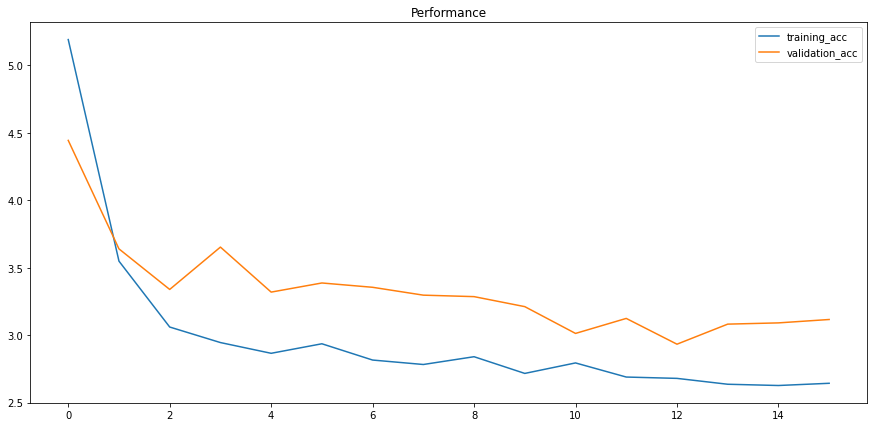

In [127]:
#plot accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(range(16), history.history['mean_squared_error'])
plt.plot(range(16), history.history['val_mean_squared_error'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Performance')

Text(0.5, 1.0, 'Loss with OpenAI-GPT2-Model')

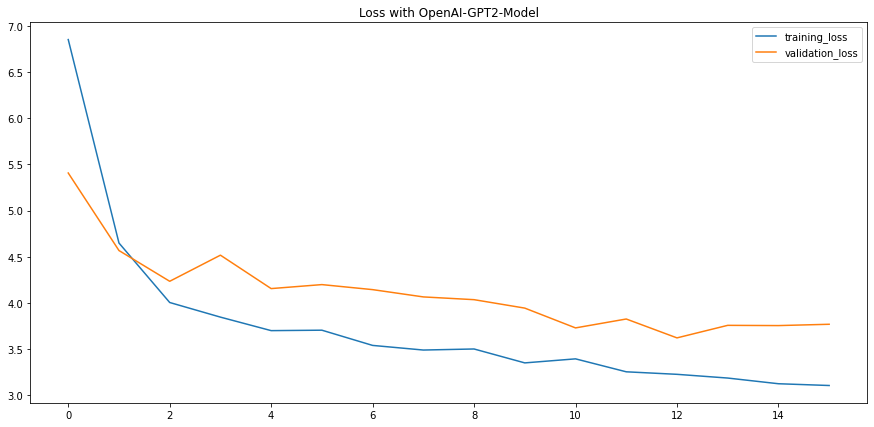

In [128]:
#plot accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(range(16), history.history['loss'])
plt.plot(range(16), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss with OpenAI-GPT2-Model')

In [129]:
y_test.shape

(2595,)

In [130]:
y_pred=model.predict([X_test_1, X_test_2])
#X_test
from sklearn.metrics import mean_squared_error
print("Mean squared error:%.2f"%mean_squared_error(y_test,y_pred))
print("Root Mean squared error:%.2f"%np.sqrt(mean_squared_error(y_test,y_pred)))

Mean squared error:2.93
Root Mean squared error:1.71


In [131]:
y_test = np.around(y_test)

In [203]:
#from sklearn.metrics import accuracy_score
#accuracy_score(y_test,y_pred)

In [132]:
from sklearn.metrics import cohen_kappa_score
y_pred = np.around(y_pred)
result = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print("Kappa Score: {}".format(result))

Kappa Score: 0.7591041045135994


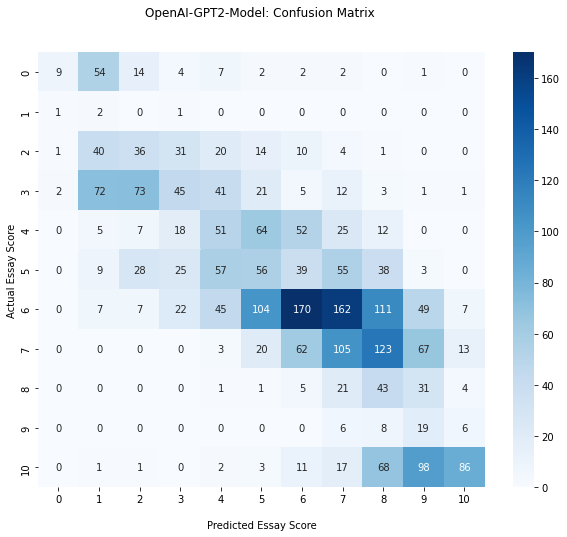

In [134]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

roberta_cm = confusion_matrix(y_test, y_pred)
#print(roberta_cm[:11,:11])
plt.figure(figsize=(10,8))
ax = sns.heatmap(roberta_cm[:11,:11], annot=True, cmap='Blues',fmt='.3g')

ax.set_title('OpenAI-GPT2-Model: Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Essay Score')
ax.set_ylabel('Actual Essay Score');

In [135]:
from sklearn.metrics import classification_report
#print(classification_report(y_test, y_pred))
clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
clsf_report.to_csv('/content/drive/MyDrive/Colab Notebooks/Transformers/OpenAI-GPT2-Model_Creport.csv', index= True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


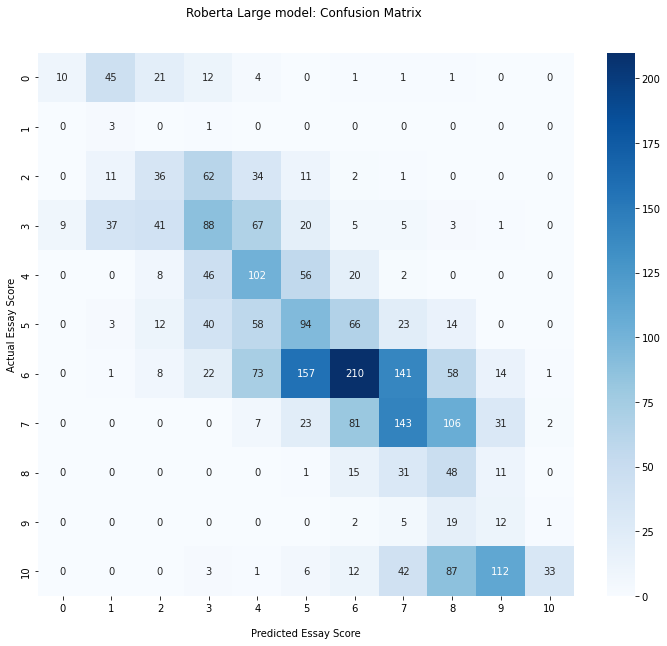

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

roberta_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
ax = sns.heatmap(roberta_cm, annot=True, cmap='Blues',fmt='.3g')

ax.set_title('Roberta Large model: Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Essay Score')
ax.set_ylabel('Actual Essay Score');

In [ ]:
#0.9587153555013579>0.9504868734802434
#Kappa Score: 0.9504868734802434

True

In [ ]:
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss, accuracy_score, multilabel_confusion_matrix, make_scorer
# coverage_error(y_test,y_pred)
# label_ranking_average_precision_score(y_test,y_pred)
# label_ranking_loss(y_test,y_pred)
accuracy_score(y_test,y_pred, normalize=False)
# multilabel_confusion_matrix(y_test,y_pred)

72

In [ ]:
## from transformers import OpenAIGPTTokenizer, TFOpenAIGPTModel
## from transformers import GPT2Tokenizer, TFGPT2Model
## from transformers import ElectraTokenizer, TFElectraModel
import tensorflow as tf

## tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
## bert_model = TFOpenAIGPTModel.from_pretrained('openai-gpt')
## tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
## bert_model = TFGPT2Model.from_pretrained('gpt2')
## tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
## bert_model = TFElectraModel.from_pretrained('google/electra-small-discriminator')

bert_model.trainable = False 

tokenizer_in = tokenizer(corpus, padding=True, truncation=True, max_length=512, return_tensors="tf")
#inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
#outputs = bert_model(inputs)

input_ids = inputs.input_ids
attention_masks = inputs.attention_mask 
token_type_ids = inputs.token_type_ids

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.
